In [3]:
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as T
from torch import optim
import numpy as np
import random
from torch.autograd import Variable

import pdb
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
import torch.cuda.amp as amp

In [4]:
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [5]:
seed = 2

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [6]:
device_ids = [0, 1, 2, 3]
batch_size = len(device_ids) * 256
device = torch.device('cuda:{}'.format(device_ids[0]))

In [7]:
IMAGE_SIZE = 32
num_classes = 10

train_transform = T.Compose(
    [
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)
test_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465), 
            (0.2023, 0.1994, 0.2010)
        ),
    ]
)
train_dataset = CIFAR10(
    root="./imgs/cifar10", train=True, download=True, transform=train_transform
)
test_dataset = CIFAR10(
    root="./imgs/cifar10", train=False, download=True, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
indices = np.random.permutation(len(train_dataset))

In [10]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam

c_models = []
c_optims = []
c_dsets = []
c_dloaders = []

num_clients = 2
samples_per_client = 10000

for i in range(num_clients):
    c_model = nn.DataParallel(models.resnet34().to(device), device_ids=device_ids)
    c_optim = optim(c_model.parameters(), lr=3e-4)
    c_idx = indices[i*samples_per_client: (i+1)*samples_per_client]
    c_dset = Subset(train_dataset, c_idx)
    c_dloader = DataLoader(c_dset, batch_size=64*len(device_ids), shuffle=True)

    c_models.append(c_model)
    c_optims.append(c_optim)
    c_dsets.append(c_dset)
    c_dloaders.append(c_dloader)

## Isolated Training

In [21]:
acc_list = {}
for i in range(num_clients):
    acc_list[str(i)] = []

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1186, in _call_impl
    return forward_call(*input, **kwargs)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torchvision/models/resnet.py", line 285, in forward
    return self._forward_impl(x)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torchvision/models/resnet.py", line 278, in _forward_impl
    x = self.avgpool(x)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1186, in _call_impl
    return forward_call(*input, **kwargs)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/modules/pooling.py", line 1183, in forward
    return F.adaptive_avg_pool2d(input, self.output_size)
  File "/u/abhi24/matlaberp3/.torchP3/lib/python3.10/site-packages/torch/nn/functional.py", line 1214, in adaptive_avg_pool2d
    return torch._C._nn.adaptive_avg_pool2d(input, _output_size)
RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.


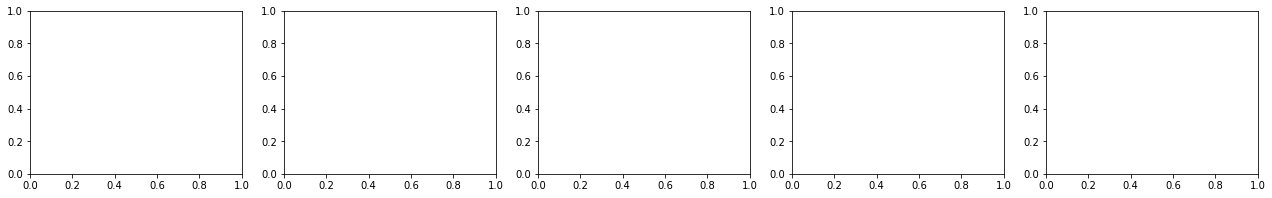

In [22]:
total_epochs = 200
fig, axs = plt.subplots(ncols=num_clients, nrows=1, figsize=(22, 3))

for epoch in range(total_epochs):
    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.eval()
        correct, total = 0, 0
        for x, y_hat in test_loader:
            with torch.no_grad():
                x, y_hat = x.to(device), y_hat.to(device)
                y = c_model(x)
                correct += (y.argmax(dim=1) == y_hat).sum()
                total += x.shape[0]
        acc = correct / total
        # print("epoch {}, client {}, acc {:.4f}".format(epoch, client_num, acc))
        acc_list[str(client_num)].append(acc.item())
    for client_num in range(num_clients):
        display.display(plt.gcf())
        display.clear_output(wait=True)
        axs[client_num].plot(acc_list[str(client_num)])

    for client_num in range(num_clients):
        c_model = c_models[client_num]
        c_model.train()
        c_optim = c_optims[client_num]
        c_dloader = c_dloaders[client_num]
        for x, y_hat in c_dloader:
            x, y_hat = x.to(device), y_hat.to(device)
            c_optim.zero_grad()
            y = c_model(x)
            loss = loss_fn(y, y_hat)
            loss.backward()
            c_optim.step()


## Save models

In [ ]:
for i in range(num_clients):
    torch.save(c_models[i].module.state_dict(), f"./saved_models/c{i}_isolated.pt")

## Load models

In [9]:
for i in range(num_clients):
    c_models[i].module.load_state_dict(torch.load(f"./saved_models/c{i}_isolated.pt"))

In [9]:
for i in range(num_clients):
    c_models[i].module.load_state_dict(torch.load(f"./saved_models/c{i}_collab.pt"))

## Evaluate on a common test-set

In [9]:
for client_num in range(num_clients):
    c_model = c_models[client_num]
    c_model.eval()
    correct, total = 0, 0
    for x, y_hat in test_loader:
        with torch.no_grad():
            x, y_hat = x.to(device), y_hat.to(device)
            y = c_model(x)
            correct += (y.argmax(dim=1) == y_hat).sum()
            total += x.shape[0]
    print("client {}, acc {:.4f}".format(client_num, correct/total))

client 0, acc 0.0000
client 1, acc 0.0008


## Collaborative Training

In [11]:
from modules import DeepInversionFeatureHook, total_variation_loss

In [12]:
mean=np.array((0.4914, 0.4822, 0.4465))
std=np.array((0.2023, 0.1994, 0.2010))

LOWER_IMAGE_BOUND = torch.tensor((-mean / std).reshape(1, -1, 1, 1)).float().to(device)
UPPER_IMAGE_BOUND = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1)).float().to(device)

In [13]:
import time

In [29]:
def run_grad_ascent_on_data(orig_img, target_label, model, lr=0.05, steps=50):
    start = time.time()
    # scaler = GradScaler()
    # print("BEFORE: memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    # print("BEFORE: memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("BEFORE: max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

    alpha_tv, alpha_l2, alpha_f = 2.5e-5, 3e-8, 10.0
    loss_r_feature_layers = []

    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(DeepInversionFeatureHook(module))

    updated_img = orig_img.detach()#.clone()
    updated_img.requires_grad = True
    updated_img.retain_grad()
    print("MIDDLE: max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
    lim_0, lim_1 = 2, 2
    for it in range(steps):
        off1 = random.randint(-lim_0, lim_0)
        off2 = random.randint(-lim_1, lim_1)
        inputs_jit = torch.roll(updated_img.detach(), shifts=(off1, off2), dims=(2,3))

        # with autocast(device_type='cuda', dtype=torch.float16):
        acts = model.module(inputs_jit)[:, :10]
        # ce_loss = nn.functional.mse_loss(target_label, acts).sum()
        ce_loss = nn.CrossEntropyLoss()(acts, target_label)

        # rescale = [first_bn_multiplier] + [1. for _ in range(len(loss_r_feature_layers)-1)]
        loss_r_feature = sum([model.r_feature for (idx, model) in enumerate(loss_r_feature_layers)])
        loss = ce_loss + alpha_tv * total_variation_loss(updated_img) + alpha_l2 * torch.linalg.norm(updated_img) + alpha_f * loss_r_feature

        loss.backward()
        # scaler.scale(loss).backward()
        # if it % 10 == 0:
        #     display.clear_output(wait=True)
        #     show(deprocess(updated_img[0]).detach().permute(1,2,0))
        #     print((updated_img - orig_img).mean())
        grads = updated_img.grad.data / (torch.std(updated_img.grad.data) + 1e-8)
        updated_img.data = updated_img.data - lr * grads
        updated_img.data = torch.clamp(updated_img.data, min=LOWER_IMAGE_BOUND, max=UPPER_IMAGE_BOUND)
        # optimizer.step()
        model.zero_grad()
        # optimizer.zero_grad()
        updated_img.grad.data.zero_()
    for item in loss_r_feature_layers:
        item.close()
    k = updated_img.detach().clone()
    print("FINAL max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
    # print((updated_img - orig_img).mean())
    del loss_r_feature_layers, inputs_jit, acts, grads, updated_img
    torch.cuda.empty_cache()
    # print("AFTER memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    # print("AFTER memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("AFTER max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
    print(time.time() - start, "seconds")
    return k

In [15]:
from torch.cuda.amp import GradScaler
from torch import autocast

In [16]:
new_acc_list = {}
for i in range(num_clients):
    new_acc_list[str(i)] = []

In [17]:
new_acc_list

{'0': [], '1': []}

In [ ]:
bs = 256
kl_loss_fn = nn.KLDivLoss(reduction="batchmean")

fig, axs = plt.subplots(ncols=num_clients, nrows=1, figsize=(22, 3))

for epoch in range(500):
    collab_data = []
    print(epoch)
    # Evaluate on the common test set
    # for client_num in range(num_clients):
    #     c_model = c_models[client_num]
    #     c_model.eval()
    #     correct, total = 0, 0
    #     for x, y_hat in test_loader:
    #         with torch.no_grad():
    #             x, y_hat = x.to(device), y_hat.to(device)
    #             y = c_model(x)
    #             correct += (y.argmax(dim=1) == y_hat).sum()
    #             total += x.shape[0]
    #     acc = correct / total
    #     new_acc_list[str(client_num)].append(acc.item())

    # Generate collab data
    for client_num in range(num_clients):
        """ We generate a zero vector of n (num_classes dimension)
        then we generate random numbers within range n and substitute
        zero at every index obtained from random number to be 1
        This way the zero vector becomes a random one-hot vector
        """
        zeroes = torch.zeros(bs, 10)
        ind = torch.randint(low=0, high=10, size=(bs,))
        zeroes[torch.arange(start=0, end=bs), ind] = 1
        target = zeroes.to(device)
        rand_imgs = torch.randn((bs, 3, 32, 32)).to(device)

        c_model = c_models[client_num]
        c_model.eval()
        print(f"generating image for client {client_num}")
        updated_imgs = run_grad_ascent_on_data(rand_imgs, target, c_model)
        with torch.no_grad():
            acts = c_model(updated_imgs)[:, :10].detach()
        collab_data.append((updated_imgs, acts))
        # print(c_models[0].module(updated_imgs).argmax(dim=1))
        # print(c_models[1].module(updated_imgs).argmax(dim=1))
        # break

    # Train each client on their own data and collab data
    # for client_num in range(num_clients):
    #     c_model = c_models[client_num]
    #     c_model.train()
    #     c_optim = c_optims[client_num]
    #     c_dloader = c_dloaders[client_num]
    #     # Train it 10 times on the same distilled dataset
    #     for _ in range(1):
    #         for c_num, (x, y_hat) in enumerate(collab_data):
    #             if c_num == client_num:
    #                 # no need to train on its own distilled data
    #                 continue
    #             x, y_hat = x.to(device), y_hat.to(device)
    #             c_optim.zero_grad()
    #             y = c_model(x)[:, :10]
    #             y = nn.functional.log_softmax(y, dim=1)
    #             loss = kl_loss_fn(y, nn.functional.softmax(y_hat, dim=1))
    #             loss.backward()
    #             c_optim.step()
    #     del x, y_hat
    #     for x, y_hat in c_dloader:
    #         x, y_hat = x.to(device), y_hat.to(device)
    #         c_optim.zero_grad()
    #         y = c_model(x)
    #         loss = loss_fn(y, y_hat)
    #         loss.backward()
    #         c_optim.step()
    print("training over")
    del collab_data, updated_imgs, acts


0
generating image for client 0
BEFORE: max_memory_reserved: 3.593750GB
MIDDLE: max_memory_reserved: 3.593750GB
FINAL max_memory_reserved: 3.593750GB
AFTER max_memory_reserved: 3.593750GB
10.405444145202637 seconds
generating image for client 1
BEFORE: max_memory_reserved: 3.593750GB
MIDDLE: max_memory_reserved: 3.593750GB
FINAL max_memory_reserved: 3.593750GB
AFTER max_memory_reserved: 3.593750GB
9.112683773040771 seconds
training over
1
generating image for client 0
BEFORE: max_memory_reserved: 3.593750GB
MIDDLE: max_memory_reserved: 3.593750GB
FINAL max_memory_reserved: 3.593750GB
AFTER max_memory_reserved: 3.593750GB
10.422072887420654 seconds
generating image for client 1
BEFORE: max_memory_reserved: 3.593750GB
MIDDLE: max_memory_reserved: 3.593750GB
FINAL max_memory_reserved: 3.593750GB
AFTER max_memory_reserved: 3.593750GB
9.109774827957153 seconds
training over
2
generating image for client 0
BEFORE: max_memory_reserved: 3.593750GB
MIDDLE: max_memory_reserved: 3.593750GB
FINAL 

In [ ]:
bs